# S2. Red convolucional para CIFAR-10

[**CIFAR-10:**](https://www.cs.toronto.edu/~kriz/cifar.html) $\;$ corpus de $60\,000$ imágenes $32\times 32$ a color RGB de 10 clases, con $6\,000$ imágenes por clase

* Publicado en 2009, CIFAR-10 es uno de los [corpus más populares en ML de los últimos años](https://paperswithcode.com/datasets?q=&v=lst&o=cited)

**Ejemplo:** $\;$ lectura de CIFAR-10

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
cifar_10_X, cifar_10_y = fetch_openml('CIFAR_10', return_X_y=True, as_frame=False, parser='auto')

Generamos la partición de $50\,000$ imágenes de training y $10\,000$ imágenes de test

In [2]:
x_train = cifar_10_X[:50000]; y_train = cifar_10_y[:50000].astype('uint8')
x_test = cifar_10_X[50000:]; y_test = cifar_10_y[50000:].astype('uint8')
labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 3072) (50000,) (10000, 3072) (10000,)


Podemos visualizar algunas de la imágenes de CIFAR-10 para valorar la complejidad de la tarea

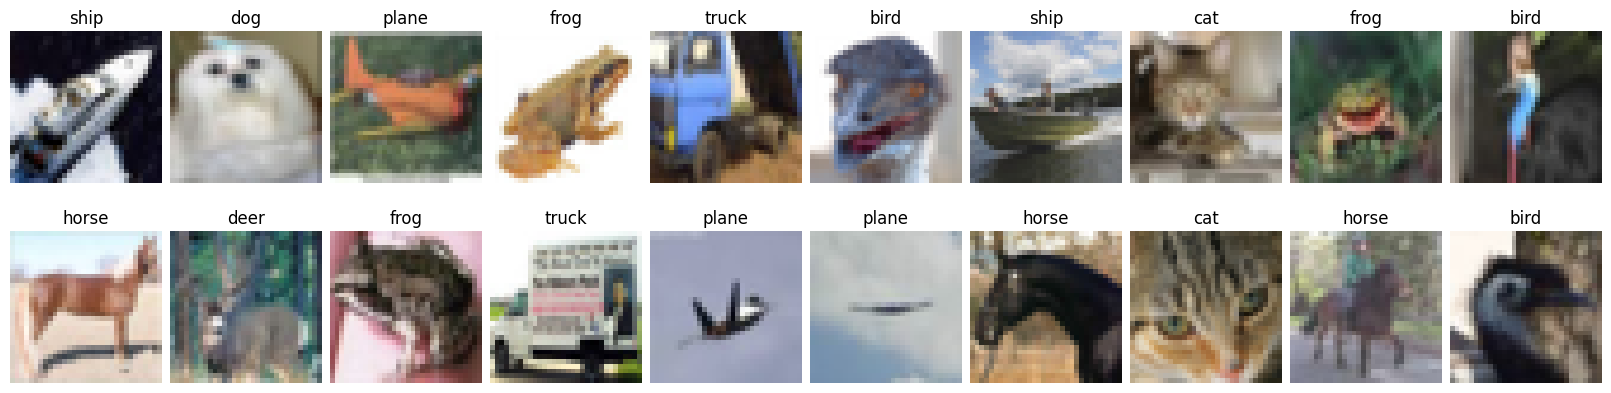

In [3]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 20*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, x_train, y_train):
    ax.set_axis_off(); image = x.reshape(3, 32, 32).transpose(1, 2, 0); ax.set_title(labels[y])
    ax.imshow(image, interpolation="none")

Como en la anterior práctica, una vez importado el conjunto de imágenes las normalizamos y definimos un conjunto de validación a partir del training

In [4]:
## Normalizar datos
from tensorflow import keras

print('training set', x_train.shape)
print('test set', x_test.shape)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

# Normalize [0..255]-->[0..1]
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = x_train.reshape(40000, 3, 32, 32)
x_val = x_val.reshape(10000, 3, 32, 32)
x_test = x_test.reshape(10000, 3, 32, 32)

print('training set', x_train.shape)
print('val set', x_val.shape)
print('test set', x_test.shape)

2023-12-05 22:07:16.110075: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 22:07:16.156569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 22:07:16.348674: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 22:07:16.348703: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 22:07:16.349783: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

training set (50000, 3072)
test set (10000, 3072)
training set (40000, 3, 32, 32)
val set (10000, 3, 32, 32)
test set (10000, 3, 32, 32)


## Modelo base
Como punto de partida tomaremos la topología base de la anterior sesión y la adaptaremos para que pueda trabajar con imágenes en RGB. Como podrás comprobar es importante especificar que los canales RGB, y por tanto los filtros resultantes, son la primera dimensión. Asegúrate que ejecutas en GPU, ya que la ejecución de AveragePooling2D en CPU da un error.
 

In [7]:
from keras import Sequential
from keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

model = Sequential()

model.add(Input((3,32,32)))
model.add(Conv2D(filters=6, kernel_size=(5,5), activation='relu', input_shape=(3,32,32),data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(2,2), strides=2, data_format='channels_first'))
model.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(2,2), strides=2, data_format='channels_first'))
model.add(Flatten(data_format='channels_first'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(units=10, activation = 'softmax'))

#model.summary()

opt=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

epochs=25
batch_size=128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr,checkpoint])  

## Cargar el mejor modelo y evaluarlo con el test set
model = keras.models.load_model('best_model.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]*100:.2f}')
print(f'Test accuracy: {score[1]*100:.2f}')

Epoch 1/25
312/313 [============================>.] - ETA: 0s - loss: 1.6527 - accuracy: 0.4008
Epoch 1: val_accuracy improved from -inf to 0.48450, saving model to best_model.h5
313/313 [==============================] - 6s 18ms/step - loss: 1.6526 - accuracy: 0.4010 - val_loss: 1.4155 - val_accuracy: 0.4845 - lr: 0.0010
Epoch 2/25
312/313 [============================>.] - ETA: 0s - loss: 1.3803 - accuracy: 0.5017
Epoch 2: val_accuracy improved from 0.48450 to 0.52570, saving model to best_model.h5
313/313 [==============================] - 6s 19ms/step - loss: 1.3801 - accuracy: 0.5016 - val_loss: 1.3122 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 3/25
311/313 [============================>.] - ETA: 0s - loss: 1.2551 - accuracy: 0.5527
Epoch 3: val_accuracy improved from 0.52570 to 0.56470, saving model to best_model.h5
313/313 [==============================] - 6s 20ms/step - loss: 1.2549 - accuracy: 0.5527 - val_loss: 1.2298 - val_accuracy: 0.5647 - lr: 0.0010
Epoch 4/25
311/313 [==

## Ejercicio:

Como podrás comprobar la tasa de acierto conseguida en CIFAR-10 dista de la conseguida en MNIST que estaba próxima al 99%. Prueba a mejorar la tasa de acierto de este modelo base aplicando las técnicas presentadas en la práctica 1 (dropout, batchnorm y aumento de datos). Considera también la posibilidad de cambiar la topología base inspirándote en otras como AlexNet, pero adaptándola a la tarea de CIFAR-10.

In [10]:
from keras import Sequential
from keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

model = Sequential()

R = 4;

model.add(Input((3,32,32)))
model.add(Conv2D(filters=96/R, kernel_size=(2,2), activation='relu', input_shape=(3,32,32), data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(3,3), strides=2, data_format='channels_first'))
model.add(Conv2D(filters=256/R, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(3,3), strides=2, data_format='channels_first'))
model.add(Conv2D(filters=384/R, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_first'))
model.add(Conv2D(filters=384/R, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_first'))
model.add(Conv2D(filters=256/R, kernel_size=(3,3), padding='same', activation='relu', data_format='channels_first'))
model.add(AveragePooling2D(pool_size=(3,3), strides=1, data_format='channels_first'))


model.add(Flatten(data_format='channels_first'))
model.add(Dense(units=4096/R, activation='relu'))
model.add(Dense(units=4096/R, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=10, activation = 'softmax'))

#model.summary()

opt=Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

epochs=25
batch_size=128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr,checkpoint])  

## Cargar el mejor modelo y evaluarlo con el test set
model = keras.models.load_model('best_model.h5')
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]*100:.2f}')
print(f'Test accuracy: {score[1]*100:.2f}')

Epoch 1/25
313/313 [==============================] - ETA: 0s - loss: 1.5300 - accuracy: 0.4426
Epoch 1: val_accuracy improved from -inf to 0.27730, saving model to best_model.h5
313/313 [==============================] - 28s 86ms/step - loss: 1.5300 - accuracy: 0.4426 - val_loss: 1.9194 - val_accuracy: 0.2773 - lr: 0.0010
Epoch 2/25
312/313 [============================>.] - ETA: 0s - loss: 1.2180 - accuracy: 0.5642
Epoch 2: val_accuracy improved from 0.27730 to 0.28780, saving model to best_model.h5
313/313 [==============================] - 34s 109ms/step - loss: 1.2180 - accuracy: 0.5642 - val_loss: 2.2959 - val_accuracy: 0.2878 - lr: 0.0010
Epoch 3/25
313/313 [==============================] - ETA: 0s - loss: 1.0676 - accuracy: 0.6202
Epoch 3: val_accuracy improved from 0.28780 to 0.29680, saving model to best_model.h5
313/313 [==============================] - 33s 105ms/step - loss: 1.0676 - accuracy: 0.6202 - val_loss: 3.1330 - val_accuracy: 0.2968 - lr: 0.0010
Epoch 4/25
313/31